# QC of ChIC cells
To select high-quality cells with good coverage and enrichment scores, in a cell type-specific manner.

## Read in all necessary packages:

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.io.parsers import read_csv

import scanpy as sc
import numpy as np
from sklearn.neighbors import NearestNeighbors


/var/folders/_k/c0bkq2m10c5f4h7vq_0xfm_40000gn/T/ipykernel_50215/1056412298.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

#scv.set_figure_params('scvelo')  # for beautified visualization
sc.set_figure_params(dpi=150, color_map = 'viridis')

scanpy==1.10.3 anndata==0.11.1 umap==0.5.7 numpy==2.0.2 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [5]:
sc.set_figure_params(dpi = 80)
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")

## Script to run:

In [6]:
def calculateCovEnr(chic_df, PCA_file, neighbors,  enrichment, n_reads, genome_size = 50000):
    chic_df = chic_df.T
    PCAs = PCA_file[PCA_file.index.isin(chic_df.index)]
    cellnames = list(PCAs.index)
    nbrs = NearestNeighbors(n_neighbors = neighbors, algorithm = 'auto').fit(PCAs)
    distances, indices = nbrs.kneighbors(PCAs)
    neighborslist = pd.DataFrame(indices)
    neighborslist.index = cellnames
    
    returndf = pd.DataFrame(columns=['QC','coverage','enrichment','reads'], index=cellnames)
    
    for name in cellnames:
        #select neighbours
        subset = chic_df.loc[(np.array(cellnames)[neighborslist.loc[name]])].T
        subset['sum'] = (subset/subset.sum(axis = 0)).sum(axis = 1)
        subset = subset.sort_values('sum', ascending=False)
        subsetsums = subset['sum']
        covercounter1  =0
        covercounter2 = 0
        counteraim = sum(subsetsums)*.8
        for counter2 in subsetsums:
            if covercounter1 < counteraim:
                covercounter1 = covercounter1+counter2
                covercounter2 = covercounter2+1

        coverage = covercounter2/genome_size
        testlist = subset[name]

        returndf.loc[name,'coverage'] = (coverage * 100)
        returndf.loc[name,'enrichment'] = ((testlist.head(round(len(testlist)*coverage))).sum()/(testlist).sum())*100
        returndf.loc[name,'reads'] = chic_df.loc[name].sum()

    returndf['QC'] = 'good'
    returndf.loc[returndf['enrichment'] < enrichment, 'QC'] = 'bad'
    returndf.loc[returndf['reads'] < n_reads, 'QC'] = 'bad'
    returndf['reads_log10']=np.log10(pd.to_numeric(returndf['reads'])+1)
    return returndf

## Load the dataframes

Load the PCA table from jupyter notebook 1a:

In [7]:
trans_csv = pd.read_csv('20230619_PCs_cells.csv', index_col = 0)

In [8]:
trans_csv.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
index,,,,,,,,,,,,,,,,,,,,,
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_341,0.964806,7.191636,-2.603931,9.105891,3.938356,1.973699,21.090298,-4.302753,-2.225135,-3.084515,...,-1.750981,-0.541662,-0.878853,-0.083634,-0.985140,0.722176,0.712043,-2.020363,0.711821,0.820616
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_310,1.116417,-3.545411,-4.362295,-2.500739,-1.401487,-2.550253,0.541622,-1.592143,0.898946,-1.456221,...,-0.618513,-0.441833,-0.222073,-0.648918,1.155978,-0.026675,0.049775,0.415757,0.558149,-0.210710


Load the merged chic csv file containing **one histone modification**

In [10]:
chic_csv_k4 = pd.read_csv('H3K4me3_merged_count_table_50000.csv', header=0, index_col=(0,1,2),low_memory=True)

/var/folders/_k/c0bkq2m10c5f4h7vq_0xfm_40000gn/T/ipykernel_50215/2576184698.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  chic_csv_k4 = pd.read_csv('H3K4me3_merged_count_table_50000.csv', header=0, index_col=(0,1,2),low_memory=True)


In [11]:
chic_csv_k4.head(2)

PZ-MB-TChIC-Gastd6-rep3-H3K4me3-4_326  \
10 3100000 3150000                                    2.0   
   3150000 3200000                                    1.0   

                    PZ-MB-TChIC-mESCs-rep4-H3K4me3-1_124  \
10 3100000 3150000                                   2.0   
   3150000 3200000                                   5.0   

                    PZ-MB-TChIC-Gastd3-rep4-H3K4me3-4_122  \
10 3100000 3150000                                    1.0   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd3-rep4-H3K4me3-5_222  \
10 3100000 3150000                                    1.0   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd5-rep3-H3K4me3-4_299  \
10 3100000 3150000                                    1.0   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd3-rep4-H3K4me3-3_23  \
10 3100000 3150000                                   1.0   
   3150000 3200000                                   NaN   

                    PZ-MB-TChIC-Gastd7-rep2-H3K4me3-6_351  \
10 3100000 3150000                                    1.0   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd3-rep4-H3K4me3-2_229  \
10 3100000 3150000                                    1.0   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd3-rep4-H3K4me3-3_255  \
10 3100000 3150000                                    1.0   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd7-rep3-H3K4me3-4_365  ...  \
10 3100000 3150000                                    1.0  ...   
   3150000 3200000                                    NaN  ...   

                    PZ-MB-TChIC-Gastd5-rep2-H3K4me3-4_73  \
10 3100000 3150000                                   NaN   
   3150000 3200000                                   NaN   

                    PZ-MB-TChIC-Gastd3-rep3-H3K4me3-5_72  \
10 3100000 3150000                                   NaN   
   3150000 3200000                                   NaN   

                    PZ-MB-TChIC-Gastd6-rep2-H3K4me3-6_73  \
10 3100000 3150000                                   NaN   
   3150000 3200000                                   NaN   

                    PZ-MB-TChIC-mESCs-rep4-H3K4me3-6_97  \
10 3100000 3150000                                  NaN   
   3150000 3200000                                  NaN   

                    PZ-MB-TChIC-Gastd3-rep3-H3K4me3-2_72  \
10 3100000 3150000                                   NaN   
   3150000 3200000                                   NaN   

                    PZ-MB-TChIC-Gastd5-rep2-H3K4me3-3_169  \
10 3100000 3150000                                    NaN   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd3-rep3-H3K4me3-6_145  \
10 3100000 3150000                                    NaN   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd6-rep2-H3K4me3-2_97  \
10 3100000 3150000                                   NaN   
   3150000 3200000                                   NaN   

                    PZ-MB-TChIC-Gastd5-rep2-H3K4me3-5_73  \
10 3100000 3150000                                   NaN   
   3150000 3200000                                   NaN   

                    PZ-MB-TChIC-Gastd5-rep2-H3K4me3-3_73  
10 3100000 3150000                                   NaN  
   3150000 3200000                                   NaN  

[2 rows x 25339 columns]

In [12]:
chic_csv_k27 = pd.read_csv('H3K27me3_merged_count_table_50000.csv', header=0, index_col=(0,1,2),low_memory=True)

/var/folders/_k/c0bkq2m10c5f4h7vq_0xfm_40000gn/T/ipykernel_50215/1819905286.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  chic_csv_k27 = pd.read_csv('H3K27me3_merged_count_table_50000.csv', header=0, index_col=(0,1,2),low_memory=True)


In [13]:
chic_csv_k27.head(2)

PZ-MB-TChIC-Gastd5-rep4-H3K27me3-3_43  \
10 3100000 3150000                                    2.0   
   3150000 3200000                                    9.0   

                    PZ-MB-TChIC-mESCs-rep4-H3K27me3-6_76  \
10 3100000 3150000                                   2.0   
   3150000 3200000                                   2.0   

                    PZ-MB-TChIC-Gastd5-rep4-H3K27me3-3_265  \
10 3100000 3150000                                     7.0   
   3150000 3200000                                     6.0   

                    PZ-MB-TChIC-Gastd4-rep4-H3K27me3-4_312  \
10 3100000 3150000                                     1.0   
   3150000 3200000                                     NaN   

                    PZ-MB-TChIC-Gastd3-rep4-H3K27me3-3_265  \
10 3100000 3150000                                     1.0   
   3150000 3200000                                     1.0   

                    PZ-MB-TChIC-mESCs-rep4-H3K27me3-1_143  \
10 3100000 3150000                                    1.0   
   3150000 3200000                                    2.0   

                    PZ-MB-TChIC-Gastd7-rep2-H3K27me3-4_267  \
10 3100000 3150000                                     1.0   
   3150000 3200000                                     2.0   

                    PZ-MB-TChIC-Gastd5-rep4-H3K27me3-3_14  \
10 3100000 3150000                                    2.0   
   3150000 3200000                                   12.0   

                    PZ-MB-TChIC-Gastd3-rep3-H3K27me3-4_202  \
10 3100000 3150000                                     1.0   
   3150000 3200000                                     3.0   

                    PZ-MB-TChIC-Gastd7-rep3-H3K27me3-4_357  ...  \
10 3100000 3150000                                     1.0  ...   
   3150000 3200000                                     NaN  ...   

                    PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_72  \
10 3100000 3150000                                    NaN   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd4-rep3-H3K27me3-1_274  \
10 3100000 3150000                                     NaN   
   3150000 3200000                                     NaN   

                    PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_145  \
10 3100000 3150000                                     NaN   
   3150000 3200000                                     NaN   

                    PZ-MB-TChIC-Gastd6-rep2-H3K27me3-6_145  \
10 3100000 3150000                                     NaN   
   3150000 3200000                                     NaN   

                    PZ-MB-TChIC-Gastd3-rep3-H3K27me3-2_274  \
10 3100000 3150000                                     NaN   
   3150000 3200000                                     NaN   

                    PZ-MB-TChIC-Gastd3-rep3-H3K27me3-3_274  \
10 3100000 3150000                                     NaN   
   3150000 3200000                                     NaN   

                    PZ-MB-TChIC-Gastd5-rep2-H3K27me3-3_73  \
10 3100000 3150000                                    NaN   
   3150000 3200000                                    NaN   

                    PZ-MB-TChIC-Gastd4-rep3-H3K27me3-5_274  \
10 3100000 3150000                                     NaN   
   3150000 3200000                                     NaN   

                    PZ-MB-TChIC-Gastd4-rep3-H3K27me3-4_274  \
10 3100000 3150000                                     NaN   
   3150000 3200000                                     NaN   

                    PZ-MB-TChIC-Gastd4-rep3-H3K27me3-2_274  
10 3100000 3150000                                     NaN  
   3150000 3200000                                     NaN  

[2 rows x 25340 columns]

## Define variables

In [14]:
enrichment_val = 65 # 
n_reads_val_k4 = 300 # we used 300 for K4, 900 for K27
n_reads_val_k27 = 900 # we used 300 for K4, 900 for K27
neighbors_val = 200

## Run code

In [15]:
QC_scores_k4 = calculateCovEnr(chic_csv_k4,trans_csv,neighbors = neighbors_val, 
                       enrichment = enrichment_val, n_reads = n_reads_val_k4)

In [16]:
QC_scores_k4.head(2)

,QC,coverage,enrichment,reads,reads_log10
PZ-MB-TChIC-Gastd5-rep2-H3K4me3-1_362,good,21.898,76.013514,888.0,2.948902
PZ-MB-TChIC-Gastd5-rep2-H3K4me3-1_288,good,21.02,73.570658,1854.0,3.268344


In [17]:
QC_scores_k27 = calculateCovEnr(chic_csv_k27,trans_csv,neighbors = neighbors_val, 
                       enrichment = enrichment_val, n_reads = n_reads_val_k27)

In [18]:
QC_scores_k27.head(2)

,QC,coverage,enrichment,reads,reads_log10
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_341,good,35.22,75.201795,53024.0,4.724481
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_310,good,32.076,67.398275,18088.0,4.257415


## Plot and evaluate results

In [46]:
def plotResults(QCval):
    fig,ax=plt.subplots(1,2, figsize = (8,4))
    
    ax[0]=sns.boxplot(data=QC_scores_k4, ax=ax[0],
                   hue="QC", y=QCval, palette=['lightgrey','lightgrey'], 
                   zorder=1, fliersize = False)
    ax[0]=sns.stripplot(data=QC_scores_k4, ax=ax[0], s = 1, 
                   hue="QC", y=QCval, palette=['green','red'],dodge = True, 
                     jitter = 0.3, zorder=1)
    
    ax[1]=sns.boxplot(data=QC_scores_k27, ax=ax[1],
                   hue="QC", y=QCval, palette=['lightgrey','lightgrey'], 
                   zorder=1, fliersize = False)
    ax[1]=sns.stripplot(data=QC_scores_k27, ax=ax[1], s = 1,
                   hue="QC", y=QCval, palette=['green','red'],dodge = True, 
                     jitter = 0.3, zorder=1)
    
    ax[0].set_title('K4me3')
    ax[1].set_title('K27me3')
    ax[0].set_xlabel('good vs bad cells')
    ax[1].set_xlabel('good vs bad cells')
    ax[0].legend([], frameon = False)
    ax[1].legend([], frameon = False)
    ax[1].set_ylabel('')
    if QCval == 'enrichment':
        ax[0].axhline(enrichment_val, ls='--', color='Black')
        ax[1].axhline(enrichment_val, ls='--', color='Black')
    plt.show()

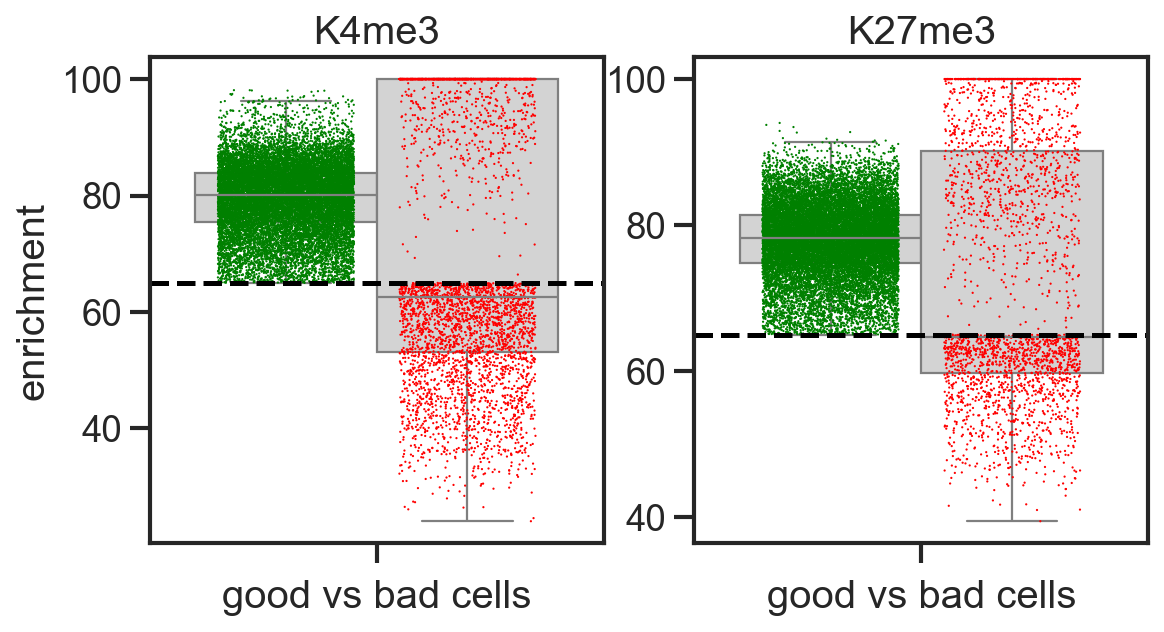

In [47]:
plotResults('enrichment')

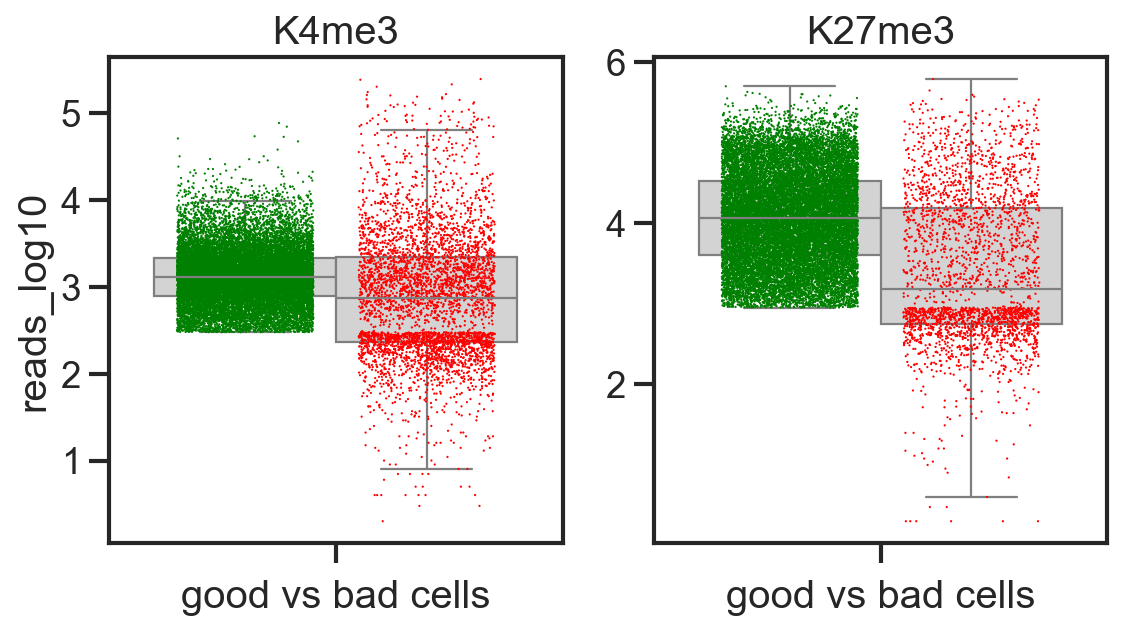

In [50]:
plotResults('reads_log10')

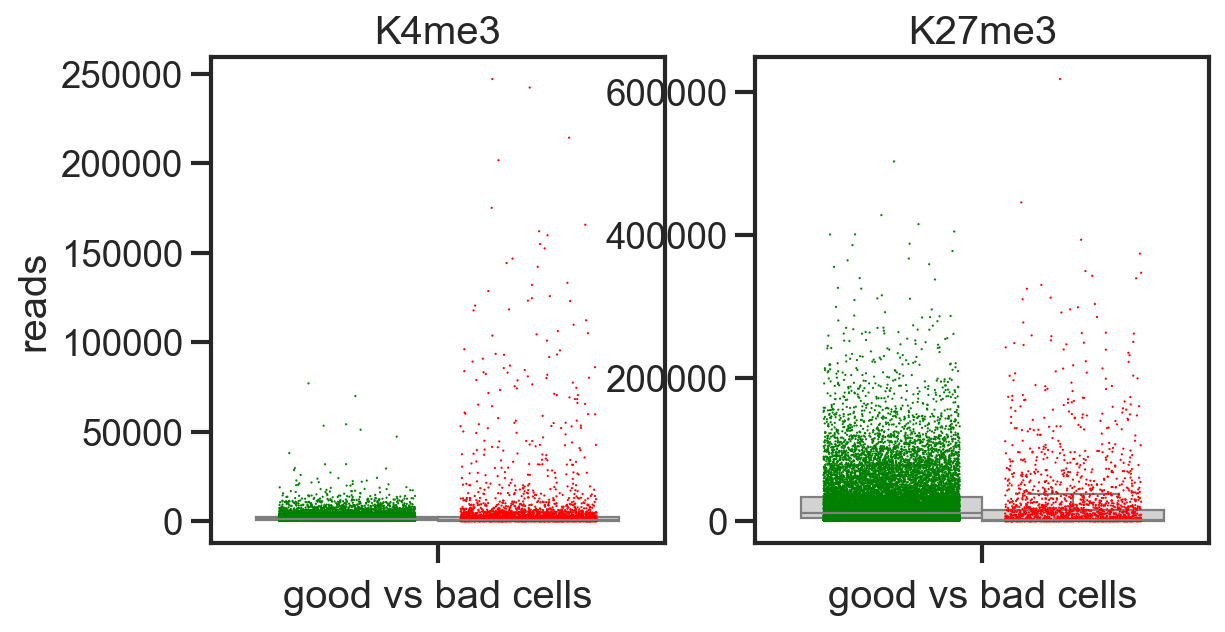

In [51]:
plotResults('reads')

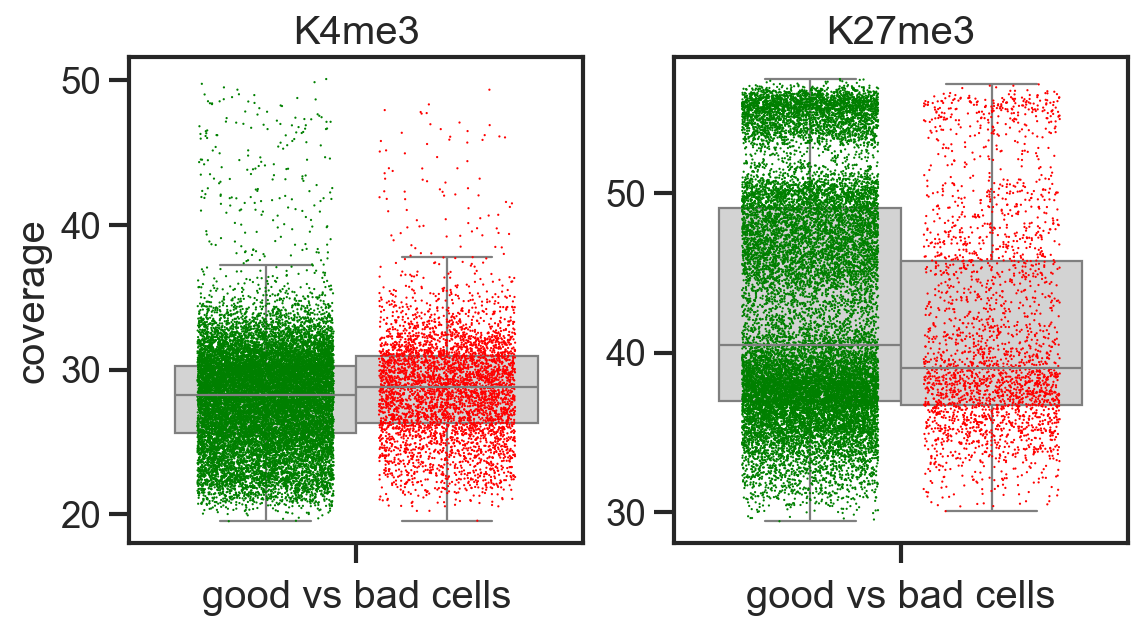

In [52]:
plotResults('coverage')

In [71]:
print('Number of cells passing QC check: ' + str(QC_scores_k27['QC'].value_counts()['good']/len(QC_scores_k27['QC'])*100))
print(QC_scores_k27['QC'].value_counts())


Number of cells passing QC check: 87.3761013215859
QC
good    19041
bad      2751
Name: count, dtype: int64


In [70]:
print('Number of cells passing QC check: ' + str(QC_scores_k4['QC'].value_counts()['good']/len(QC_scores_k4['QC'])*100))
print(QC_scores_k4['QC'].value_counts())


Number of cells passing QC check: 79.62877458675777
QC
good    17246
bad      4412
Name: count, dtype: int64


In [ ]:
#save results
QC_scores_k4.to_csv('testresults_H3K4me3_final_all.csv')
QC_scores_k27.to_csv('testresults_H3K27me3_final_all.csv')